## Creating the coordinate files for the labeled subset of our network

- In this notebook, I am creating a labelled version of the full edgelist. Markers are labeled as high or low SES based on expert knowledge. This is subsequently to be used as input in the CORG method for model validation.
- Secondly, I am fitting the CA pipeline on all models. All coordinate files for the subsets are saved in separate folders. 
- Important to note, the CA is performed with all markers available. It is only in the CORG method that the labeled markers are relevant

In [8]:
# Standard library imports
import sys

# Third party imports
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import prince
from networkx.algorithms import bipartite
from matplotlib.patches import Patch
import community as community_louvain
from netgraph import Graph

# Local application imports
sys.path.insert(0, '../Utility files')
from corg import DiscoverDimension, BenchmarkDimension
import utils2
from utils2 import *
import graphfunk
from graphfunk import *
import ca_pipeline
from ca_pipeline import PipelineCorAnalysis
from matplotlib.ticker import FuncFormatter


### 1. Create the labeled subset

Create an empty csv file to fill in manualy (High vs. Low SES)

- The data used to create the labeled df contains a row for each follower relationship a brand has. It includes the original type column, as well as the changed column (condensed from 12 to 4 types.)
- Additionally, it has been filtered to only include markers with more than 100 followers

In [ ]:

# # load data
# path = '/home/livtollanes/NewData/french/french_edgelist_marker_threshold.csv'

# req_cols = ['marker_id', 'follower_id', 'twitter_name','followers','french_followers', 'type', 'type2']
# dtypes = {'marker_id': 'object',
#           'follower_id': 'object',
#           'twitter_name': 'object',
#           'followers': 'int64',
#           'french_followers': 'int64',
#           'type': 'object',
#           'type2': 'object'}


# edgelist_CORG = pd.read_csv(path, usecols=req_cols, dtype=dtypes)

# #Separate my data frame into dictionary of types
# def create_dict(df, key_col, value_col):
#     unique_df = df.drop_duplicates(subset=[key_col, value_col])
#     return unique_df.groupby(key_col)[value_col].apply(list).to_dict()


# df_dict = create_dict(edgelist_CORG, 'type', 'twitter_name')
# df_dict2 = create_dict(edgelist_CORG, 'type2', 'twitter_name')


# for key, value in df_dict.items():
#     value = list(set(value))
#     print(f"Key: {key}")
#     print(f"Value: {value}\n")



# # Create a csv file to use for labeling 
# rows = []
# for key, values in df_dict.items():
#     for value in values:
#         row = {'type': key, 'twitter_name': value, 'high': '', 'low': ''}
#         rows.append(row)

# # Now we write the rows to a CSV file
# keys = ['type', 'twitter_name', 'high', 'low']

# with open('/home/livtollanes/10.jan-thesis/labeldata/labeled_markers_empty.csv', 'w', newline='') as output_file:
#     dict_writer = csv.DictWriter(output_file, keys)
#     dict_writer.writeheader()
#     dict_writer.writerows(rows)

Load filled label data

In [22]:
# load data (this is the full list of markers together with the labels) 223 markers
path = '/home/livtollanes/10.jan-thesis/labeldata/filled_labels_markers.csv'

req_cols = ['type', 'twitter_name', 'high', 'low', 'other']
dtypes = {'type': 'object',
          'twitter_name': 'object',
          'high': 'object',
          'low': 'object',
          'other': 'object'}

labels_hl = pd.read_csv(path, usecols=req_cols, dtype=dtypes)

Now, reformat the filled in label df

I put 0: low, 1: high, NA: other

In [28]:
# Create the labeled marker df to input to the CORG method

# Create a copy of labels_hl
labels_CORG = labels_hl.copy()

# Create 'SES' column
labels_CORG['label'] = np.where(labels_CORG['high'] == '1', '1', 
                              np.where(labels_CORG['low'] == '1', '0', 'NA'))


#0: low, 1: high, NA: other

# Drop the rows where 'SES' is 'drop'
labels_CORG = labels_CORG[labels_CORG['label'] != 'drop']

# Keep only 'twitter_name' and 'SES' columns
labels_CORG = labels_CORG[['twitter_name', 'type', 'label']]

labels_CORG['label'].value_counts() # 22 H, 14 L. Looks correct

In [30]:
# load full marker edgelist data. All follower relationships
path = '/home/livtollanes/NewData/french/french_edgelist_marker_threshold.csv'

req_cols = ['marker_id', 'follower_id', 'twitter_name','followers','french_followers', 'type', 'type2']
dtypes = {'marker_id': 'object',
          'follower_id': 'object',
          'twitter_name': 'object',
          'followers': 'int64',
          'french_followers': 'int64',
          'type': 'object',
          'type2': 'object'}


all = pd.read_csv(path, usecols=req_cols, dtype=dtypes)



In [31]:
labels_CORG_subset = labels_CORG[['twitter_name', 'label']]
all_labeled = all.merge(labels_CORG_subset, how='left', on='twitter_name')

#Save the labeled edgelist to csv in /home/livtollanes/NewData
#all_labeled.to_csv('/home/livtollanes/NewData/french/labeled_edgelist_hl.csv', index=False)

### 2. Obtaining CA coordinate files for all models 

#### 2.1 Creating models

In [2]:
# load the labeled marker edgelist (labeled markers and their followers). This df still contains all markers, but only some are labeled
path = '/home/livtollanes/NewData/french/labeled_edgelist_hl.csv'

req_cols = ['marker_id', 'follower_id', 'twitter_name','followers','french_followers', 'type', 'type2', 'label']
dtypes = {'marker_id': 'object',
          'follower_id': 'object',
          'twitter_name': 'object',
          'followers': 'int64',
          'french_followers': 'int64',
          'type': 'object',
          'type2': 'object',
          'label': 'object'}


m1_df = pd.read_csv(path, usecols=req_cols, dtype=dtypes)

In [3]:
# create models for different subsets of the data - only including certain marker configurations
m2_df = m1_df[m1_df['type'] != 'party']
m3_df = m1_df[~m1_df['type'].isin(['media', 'party', 'universities'])]
m4_df = m1_df[~m1_df['type'].isin(['media', 'party', 'universities', 'clubs de football'])]
m5_df = m1_df[~m1_df['type'].isin(['media', 'party', 'universities', 'clubs de football', 'luxe vetements et malls'])]

selected_twitter_names = ['Dior', 'CHANEL', 'LouisVuitton', 'YSL', 'Cartier', 'Hermes_Paris', 'VeuveClicquot']
m6_df = m1_df[~((m1_df['type'] == 'party') | 
                (m1_df['type'] == 'media') |
                (m1_df['type'] == 'universities') | 
                (m1_df['type'] == 'clubs de football') |
                ((m1_df['type'] == 'luxe vetements et malls') & (m1_df['twitter_name'].isin(selected_twitter_names))))]


m7_df = m1_df[m1_df['type'].isin(['chain restaurants', 'commerce', 'grande distribution', 'sport', 'luxe vetements et malls'])]
m8_df = m1_df[m1_df['type'].isin(['magazine', 'media'])]
m9_df = m1_df[m1_df['type'].isin(['universities', 'ecoles de commerce', 'Lycées professionels'])]


In [4]:
dataframes = {
    'm1_df': m1_df,
    'm2_df': m2_df,
    'm3_df': m3_df,
    'm4_df': m4_df,
    'm5_df': m5_df,
    'm6_df': m6_df,
    'm7_df': m7_df,
    'm8_df': m8_df,
    'm9_df': m9_df
}

for name, df in dataframes.items():
    num_unique_follower_ids = df['follower_id'].nunique()
    print(f'{name} number of unique follower_id: {num_unique_follower_ids}')

m1_df number of unique follower_id: 115079
m2_df number of unique follower_id: 115048
m3_df number of unique follower_id: 105582
m4_df number of unique follower_id: 101885
m5_df number of unique follower_id: 100650
m6_df number of unique follower_id: 100869
m7_df number of unique follower_id: 51322
m8_df number of unique follower_id: 108843
m9_df number of unique follower_id: 36577


#### 2.2 Fitting CA

Here, I fit the CA on each of the models. Each time, all markers included in a given model is being used. Resultantly, the coordinate file sthat are created hold for the full graph. The labelling of the markers comes into play in the CORG step. 

In [4]:
import ca_pipeline
import importlib

importlib.reload(ca_pipeline)

<module 'ca_pipeline' from '/home/livtollanes/10.jan-thesis/Code/Validation/../Utility files/ca_pipeline.py'>

In [39]:
m1_df.head()

,marker_id,follower_id,twitter_name,type,followers,french_followers,type2,label
0,19976004,1193293102162862080,Mediapart,media,3079643,64182,information,NaN
1,19976004,2884619299,Mediapart,media,3079643,64182,information,NaN
2,19976004,782999494703054848,Mediapart,media,3079643,64182,information,NaN
3,19976004,124458686,Mediapart,media,3079643,64182,information,NaN
4,19976004,2960220189,Mediapart,media,3079643,64182,information,NaN


Number of nodes: 115302
Edge number is sane - matches the number of rows in the inputted edgelist
Is the graph connected? True
Number of weakly connected components: 1
Size of largest weakly connected component: 115302
Number of strongly connected components: 115302
Size of largest strongly connected component: 1


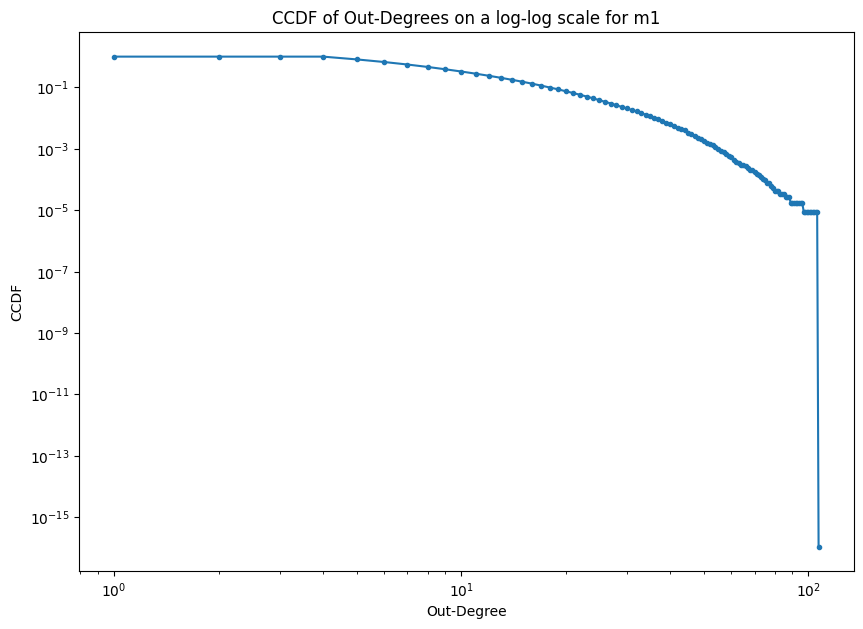

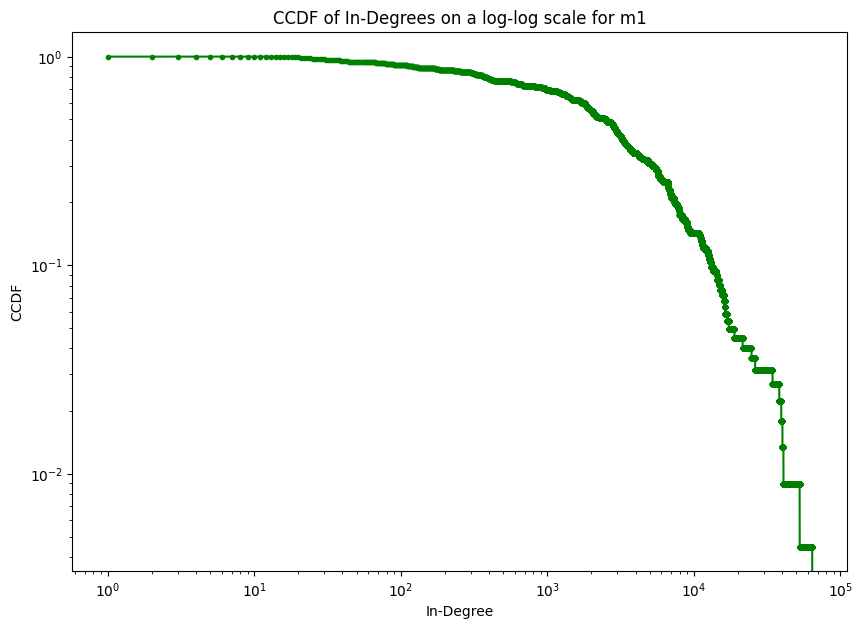

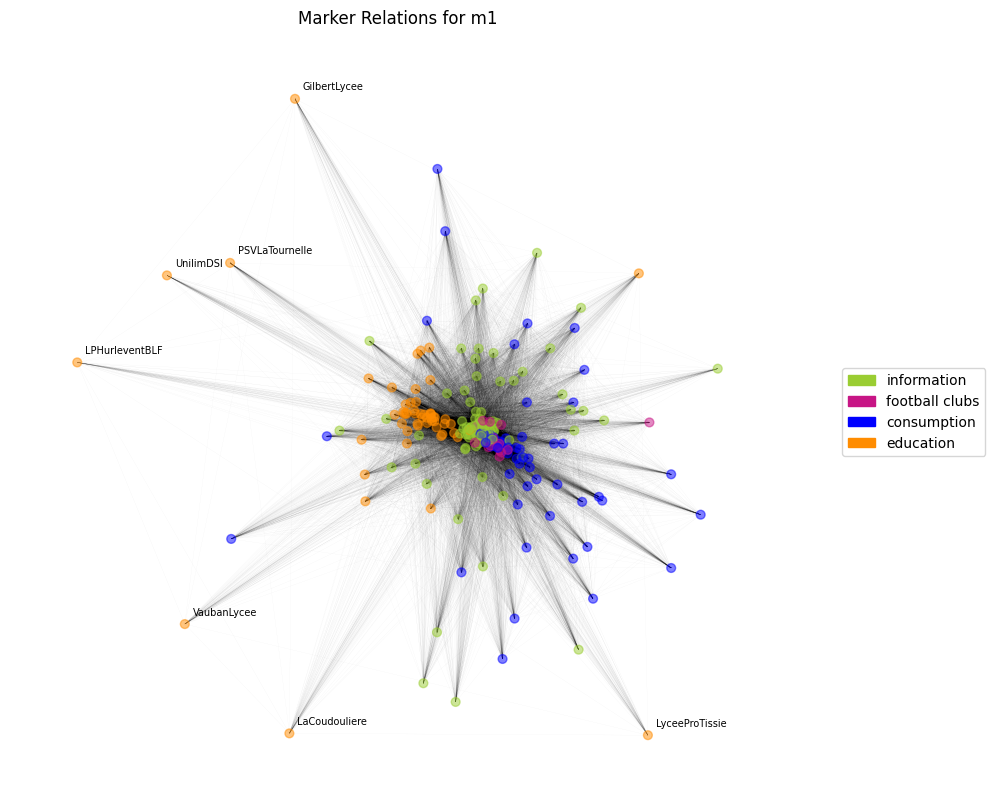

Number of communities: 4
Marker: Mediapart, Type: information, In-Degree Centrality: 0.5566300379007988
Marker: BFMTV, Type: information, In-Degree Centrality: 0.4565528486309746
Marker: LEXPRESS, Type: information, In-Degree Centrality: 0.35383908205479575
Marker: franceculture, Type: information, In-Degree Centrality: 0.3481929905204639
Marker: Europe1, Type: information, In-Degree Centrality: 0.34173164152956176


In [41]:
#m1
importlib.reload(ca_pipeline)
subset_name = 'm1'
labeled = ca_pipeline.PipelineCorAnalysis(m1_df, subset_name)
path = '/home/livtollanes/NewData/coordinates'
#labeled.run_all(path)
labeled.perform_graph_checks()
#labeled.perform_ca_pipeline(path)


Number of nodes: 115245
Edge number is sane - matches the number of rows in the inputted edgelist
Is the graph connected? True
Number of weakly connected components: 1
Size of largest weakly connected component: 115245
Number of strongly connected components: 115245
Size of largest strongly connected component: 1


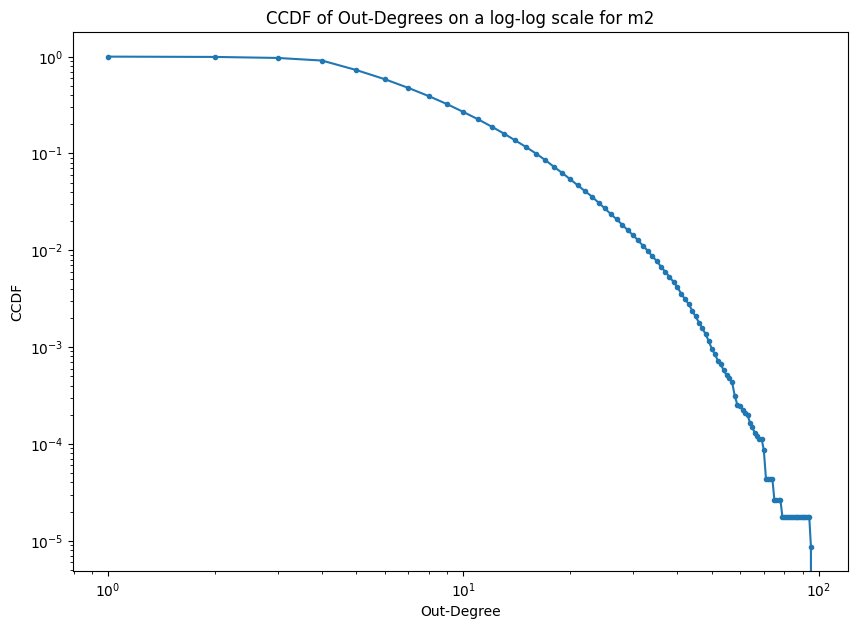

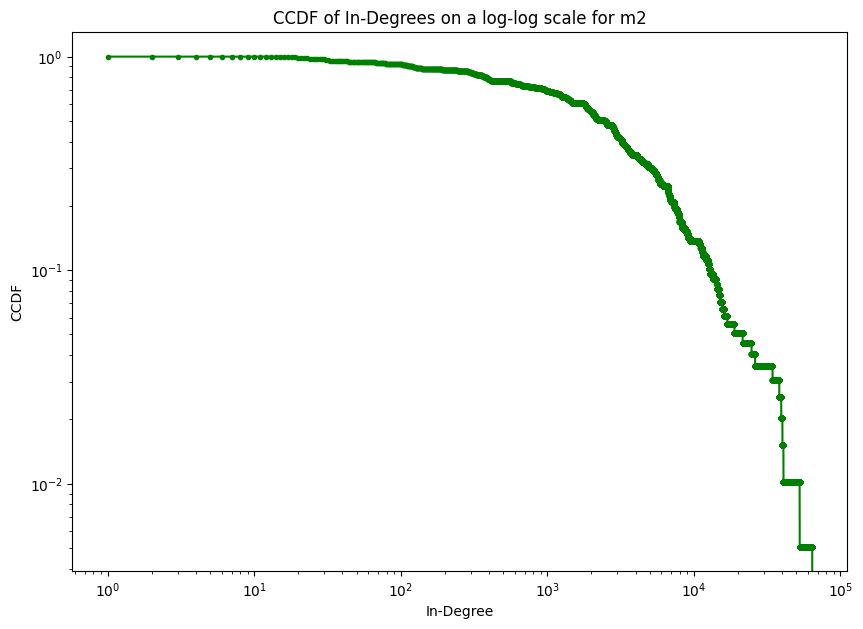

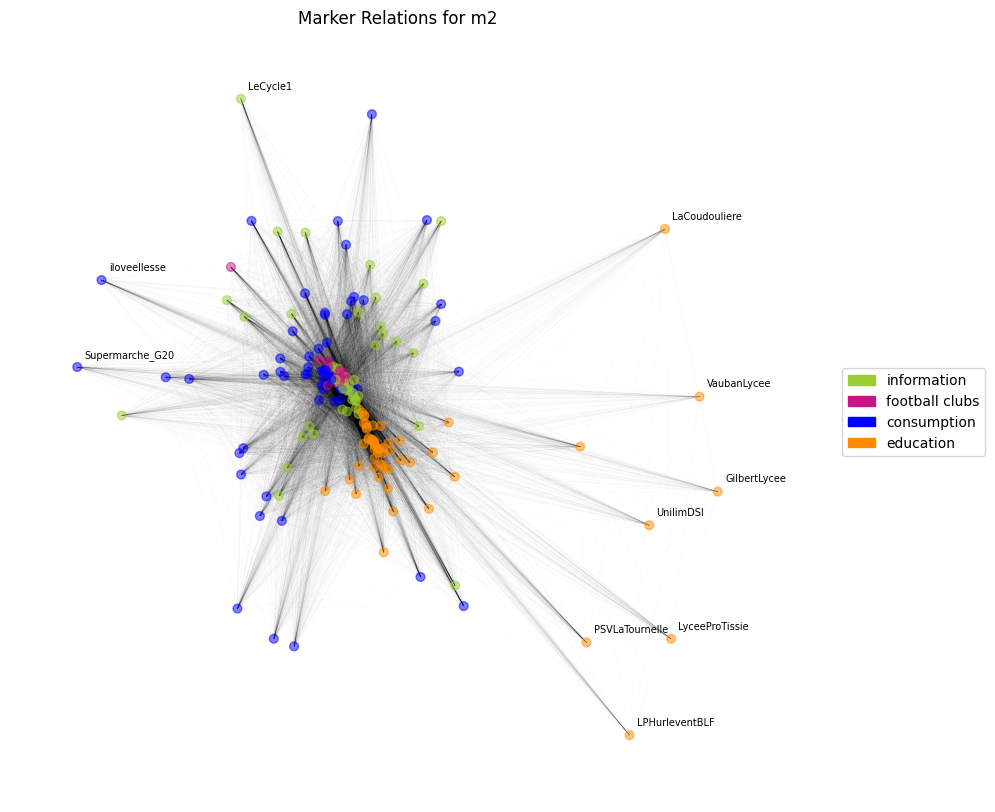

Number of communities: 4
Marker: Mediapart, Type: information, In-Degree Centrality: 0.5569053486515566
Marker: BFMTV, Type: information, In-Degree Centrality: 0.4567786609281177
Marker: LEXPRESS, Type: information, In-Degree Centrality: 0.3540140918399222
Marker: franceculture, Type: information, In-Degree Centrality: 0.34836520773315743
Marker: Europe1, Type: information, In-Degree Centrality: 0.3419006629412377


In [42]:
#m2
importlib.reload(ca_pipeline)
subset_name = 'm2'
labeled = ca_pipeline.PipelineCorAnalysis(m2_df, subset_name)
path = '/home/livtollanes/NewData/coordinates'
#labeled.run_all(path)
labeled.perform_graph_checks()




Number of nodes: 105711
Edge number is sane - matches the number of rows in the inputted edgelist
Is the graph connected? True
Number of weakly connected components: 1
Size of largest weakly connected component: 105711
Number of strongly connected components: 105711
Size of largest strongly connected component: 1


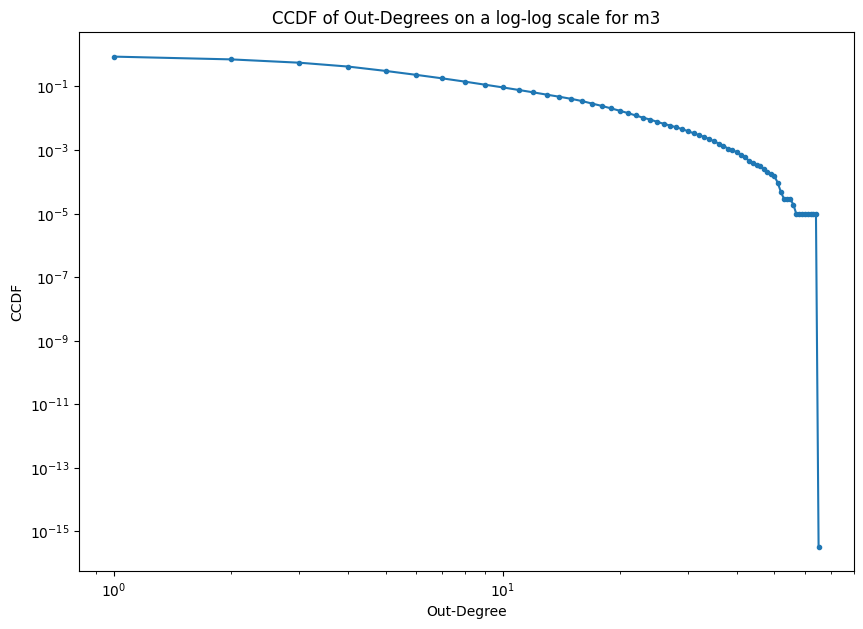

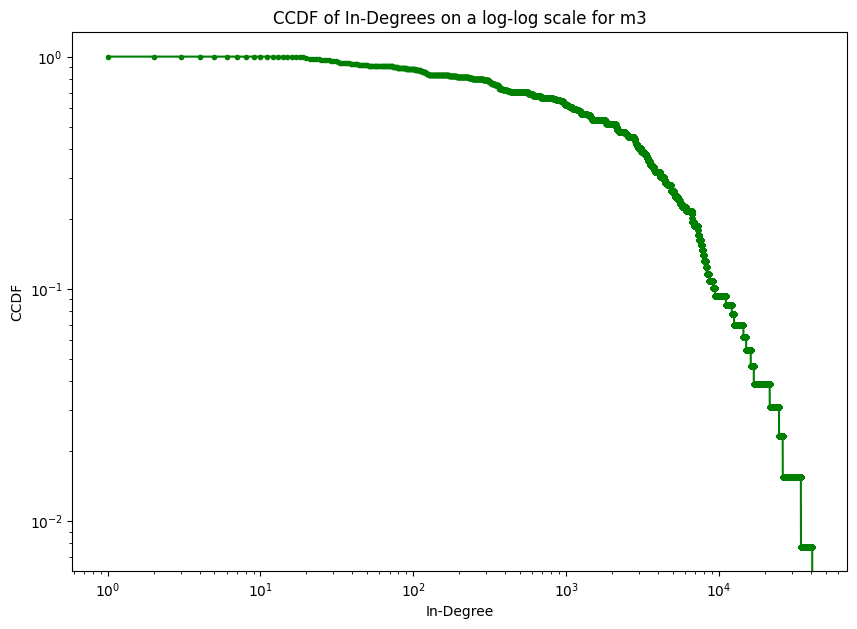

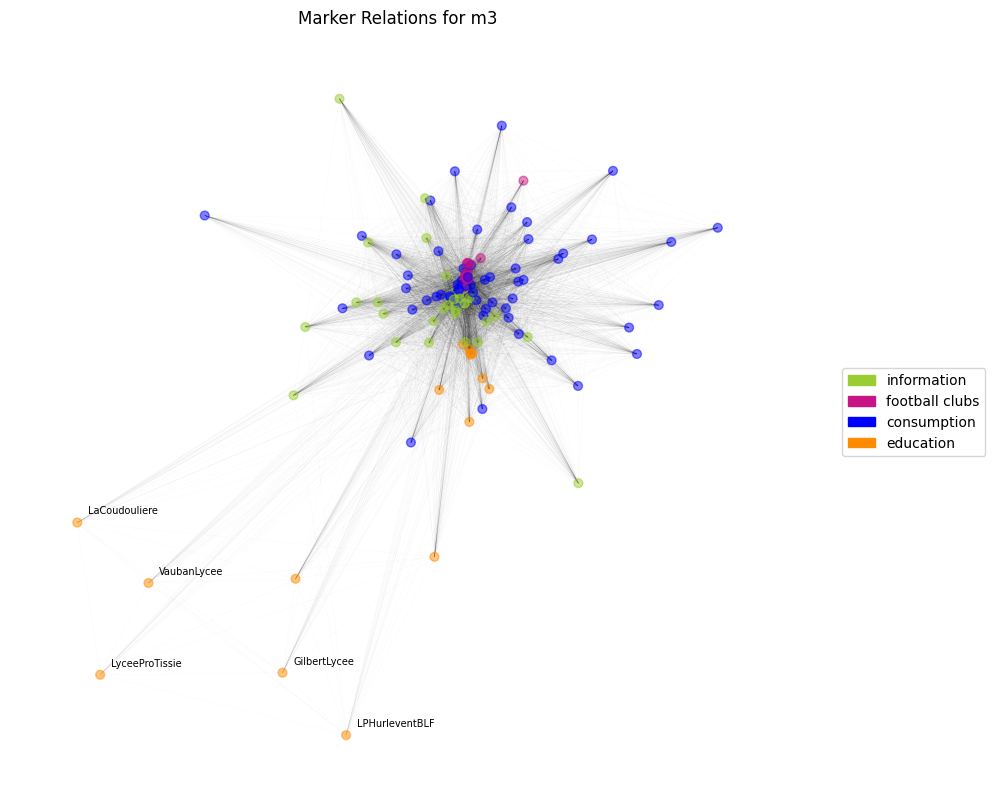

Number of communities: 3
Marker: LEXPRESS, Type: information, In-Degree Centrality: 0.38594267335162236
Marker: lesinrocks, Type: information, In-Degree Centrality: 0.32512534291930756
Marker: Telerama, Type: information, In-Degree Centrality: 0.2472140762463343
Marker: courrierinter, Type: information, In-Degree Centrality: 0.2337527197048529
Marker: PSG_inside, Type: football clubs, In-Degree Centrality: 0.2032163466086463


In [43]:
#m3
importlib.reload(ca_pipeline)
subset_name = 'm3'
labeled = ca_pipeline.PipelineCorAnalysis(m3_df, subset_name)
path = '/home/livtollanes/NewData/coordinates/'
#labeled.run_all(path)
labeled.perform_graph_checks()



Number of nodes: 101996
Edge number is sane - matches the number of rows in the inputted edgelist
Is the graph connected? True
Number of weakly connected components: 1
Size of largest weakly connected component: 101996
Number of strongly connected components: 101996
Size of largest strongly connected component: 1


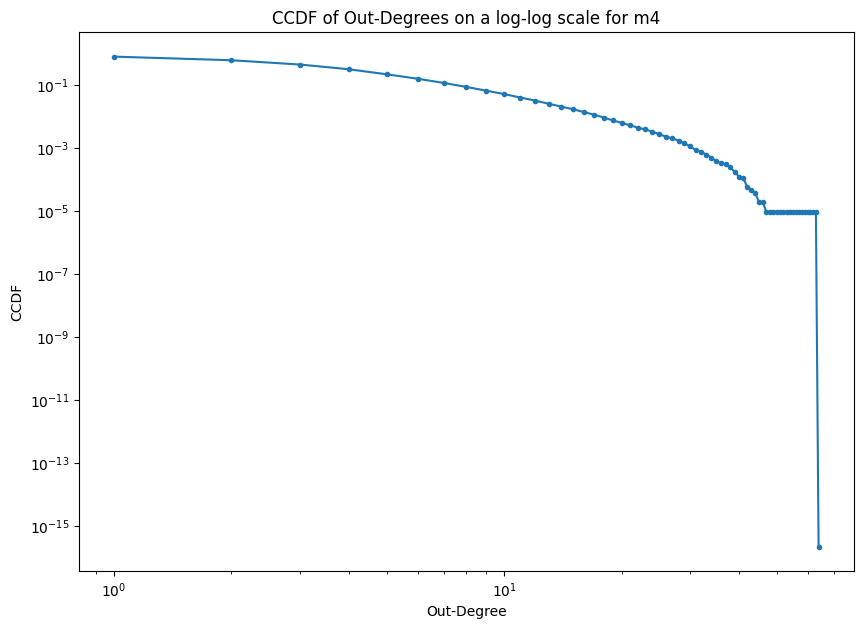

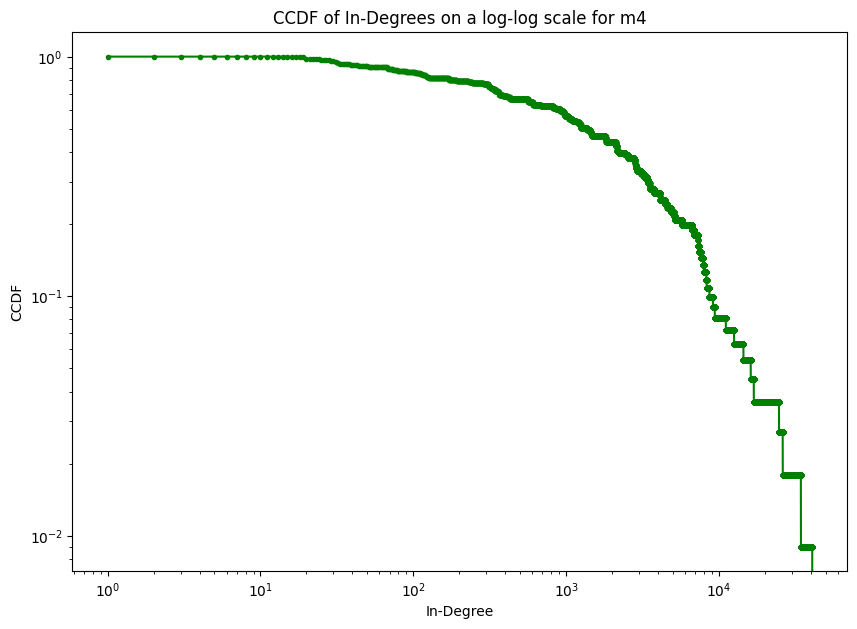

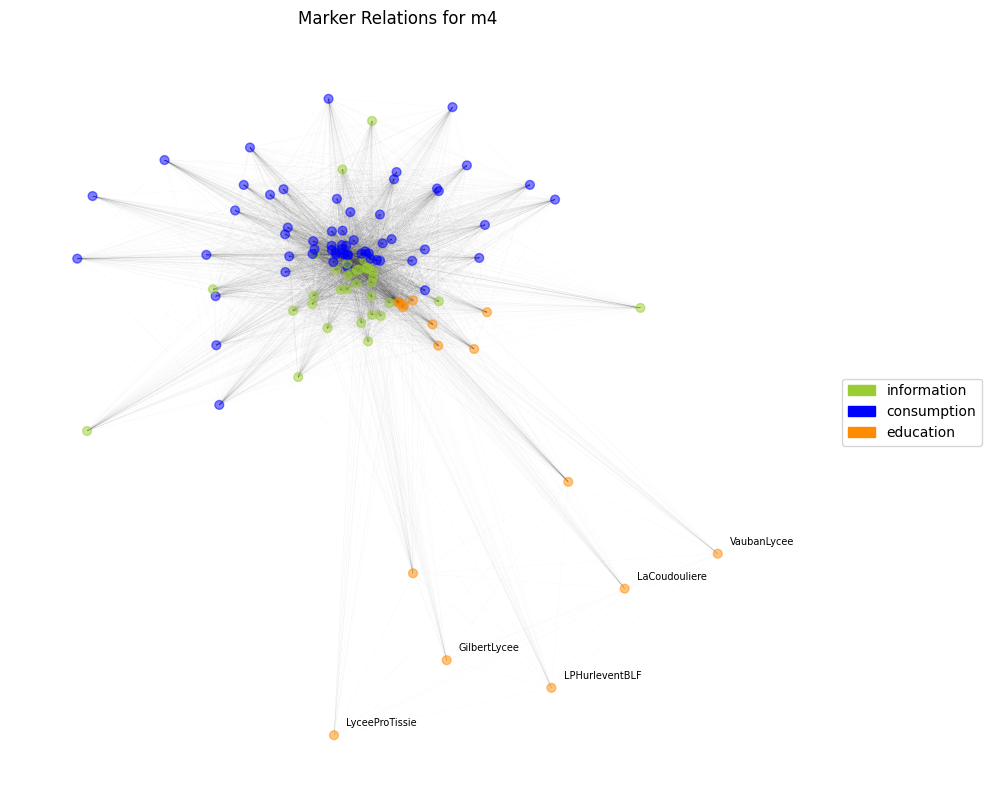

Number of communities: 4
Marker: LEXPRESS, Type: information, In-Degree Centrality: 0.4
Marker: lesinrocks, Type: information, In-Degree Centrality: 0.33696749840678464
Marker: Telerama, Type: information, In-Degree Centrality: 0.25621844208049416
Marker: courrierinter, Type: information, In-Degree Centrality: 0.24226677778322467
Marker: ParisMatch, Type: information, In-Degree Centrality: 0.1656943967841561


In [44]:
#m4
importlib.reload(ca_pipeline)
subset_name = 'm4'
labeled = ca_pipeline.PipelineCorAnalysis(m4_df, subset_name)
path = '/home/livtollanes/NewData/coordinates/'
#labeled.run_all(path)
labeled.perform_graph_checks()


Number of nodes: 100748
Edge number is sane - matches the number of rows in the inputted edgelist
Is the graph connected? True
Number of weakly connected components: 1
Size of largest weakly connected component: 100748
Number of strongly connected components: 100748
Size of largest strongly connected component: 1


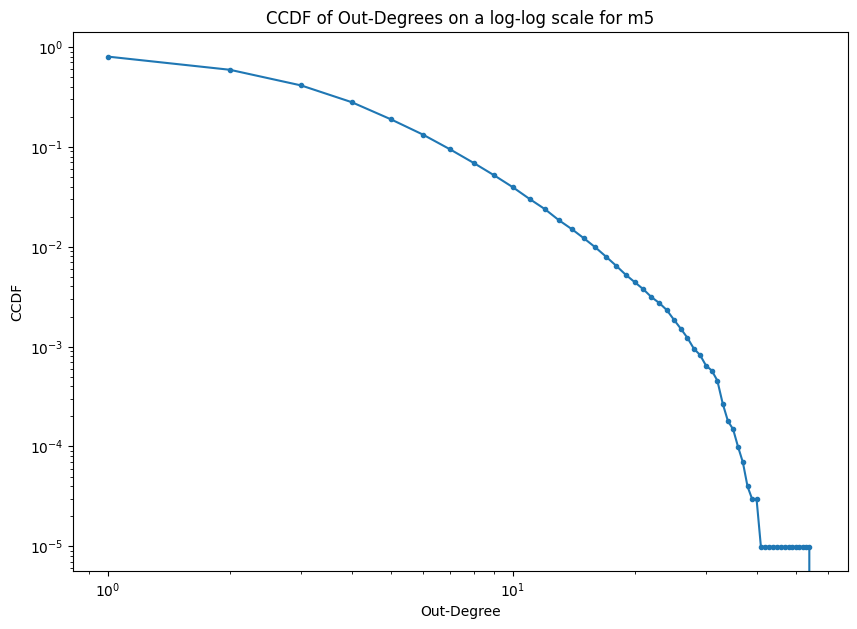

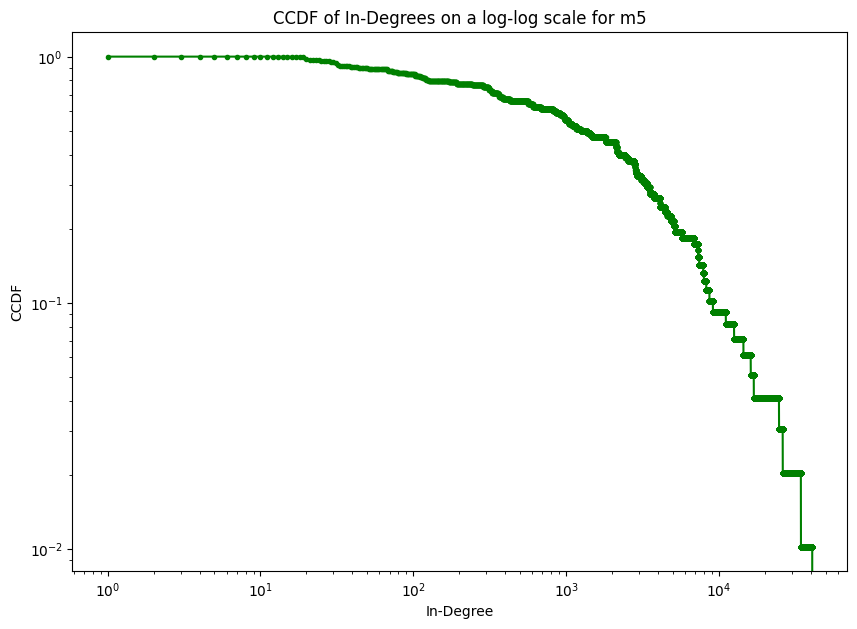

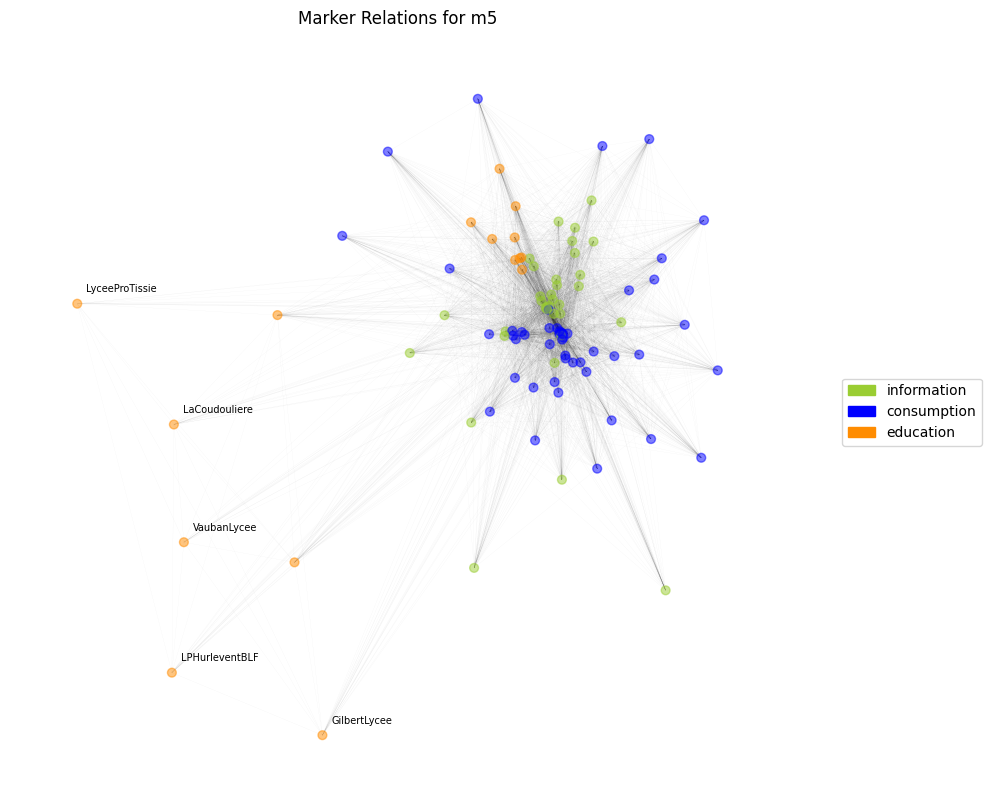

Number of communities: 3
Marker: LEXPRESS, Type: information, In-Degree Centrality: 0.4049549862526924
Marker: lesinrocks, Type: information, In-Degree Centrality: 0.341141671712309
Marker: Telerama, Type: information, In-Degree Centrality: 0.2593923392259819
Marker: courrierinter, Type: information, In-Degree Centrality: 0.24526784916672456
Marker: ParisMatch, Type: information, In-Degree Centrality: 0.16774693042969022


In [45]:
#m5
importlib.reload(ca_pipeline)
subset_name = 'm5'
labeled = ca_pipeline.PipelineCorAnalysis(m5_df, subset_name)
path = '/home/livtollanes/NewData/coordinates/'
#labeled.run_all(path)
labeled.perform_graph_checks()



Number of nodes: 100973
Edge number is sane - matches the number of rows in the inputted edgelist
Is the graph connected? True
Number of weakly connected components: 1
Size of largest weakly connected component: 100973
Number of strongly connected components: 100973
Size of largest strongly connected component: 1


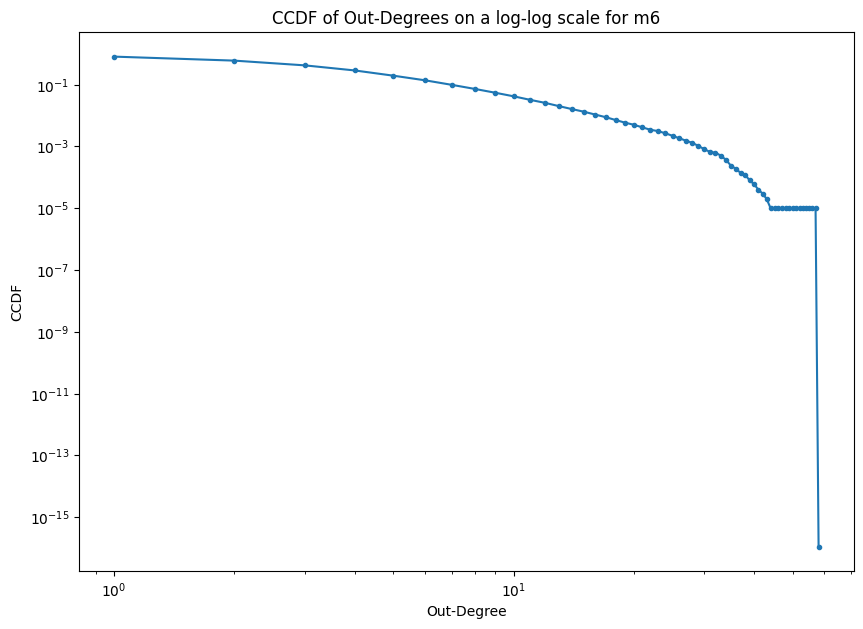

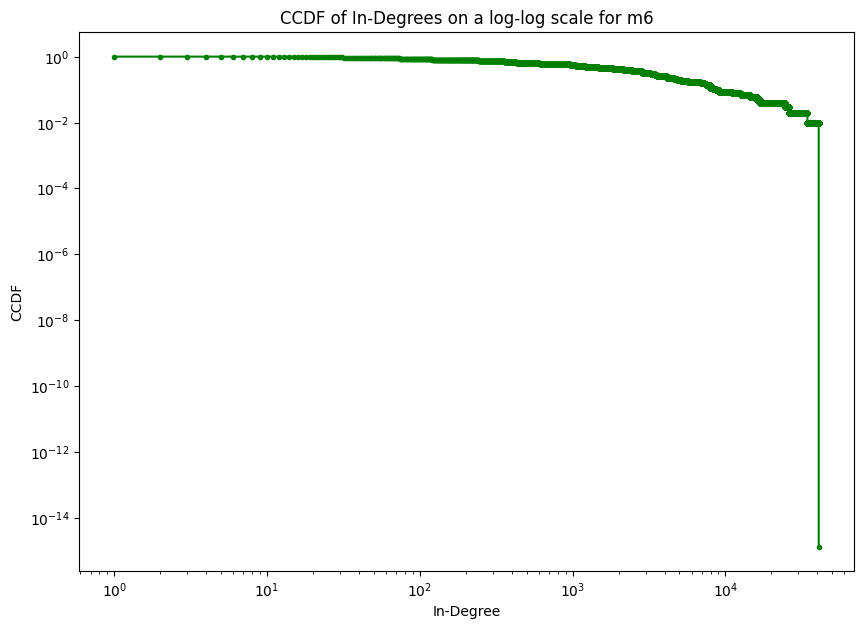

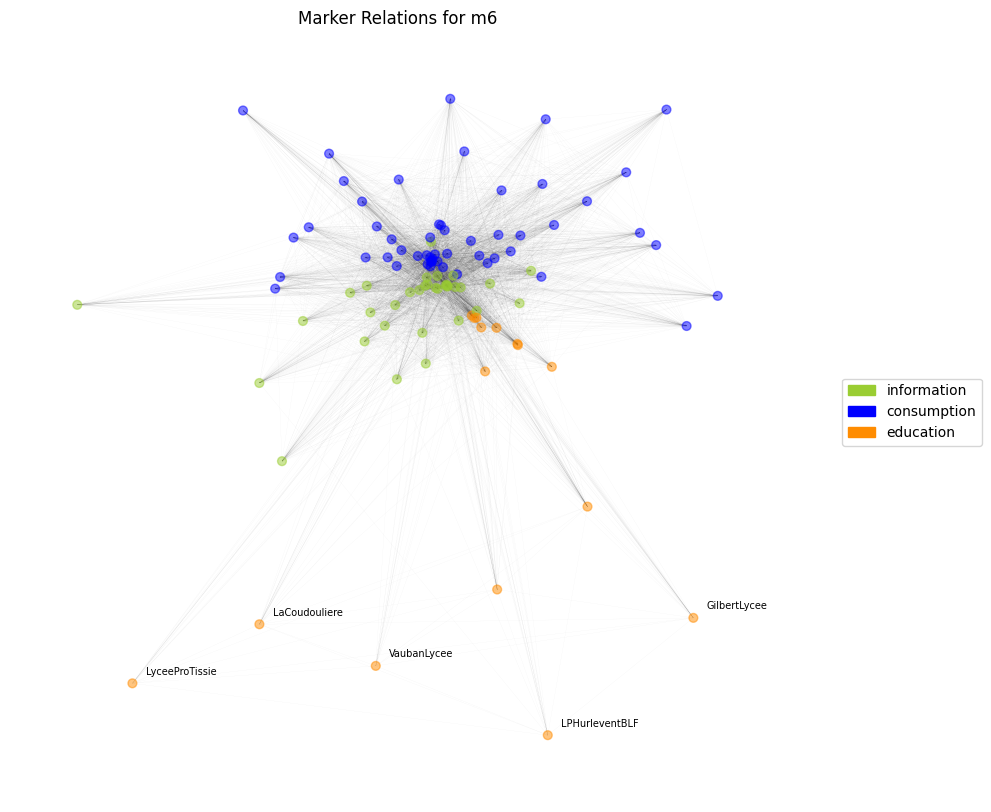

Number of communities: 3
Marker: LEXPRESS, Type: information, In-Degree Centrality: 0.40405260864398046
Marker: lesinrocks, Type: information, In-Degree Centrality: 0.34038149189874417
Marker: Telerama, Type: information, In-Degree Centrality: 0.2588143247633007
Marker: courrierinter, Type: information, In-Degree Centrality: 0.24472130887770865
Marker: ParisMatch, Type: information, In-Degree Centrality: 0.16737313314582258


In [46]:
#m6
importlib.reload(ca_pipeline)
subset_name = 'm6'
labeled = ca_pipeline.PipelineCorAnalysis(m6_df, subset_name)
path = '/home/livtollanes/NewData/coordinates/'
#labeled.run_all(path)
labeled.perform_graph_checks()


Number of nodes: 51383
Edge number is sane - matches the number of rows in the inputted edgelist
Is the graph connected? True
Number of weakly connected components: 1
Size of largest weakly connected component: 51383
Number of strongly connected components: 51383
Size of largest strongly connected component: 1


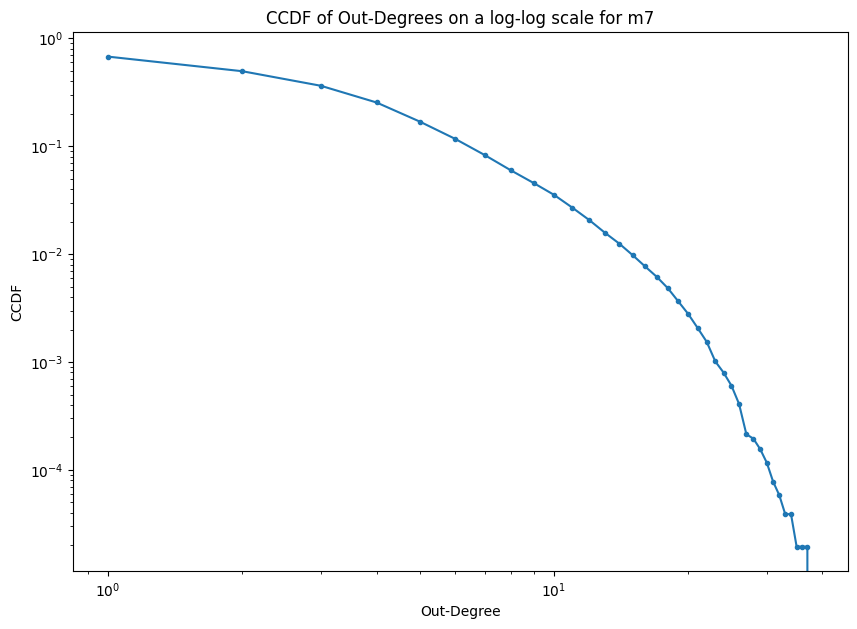

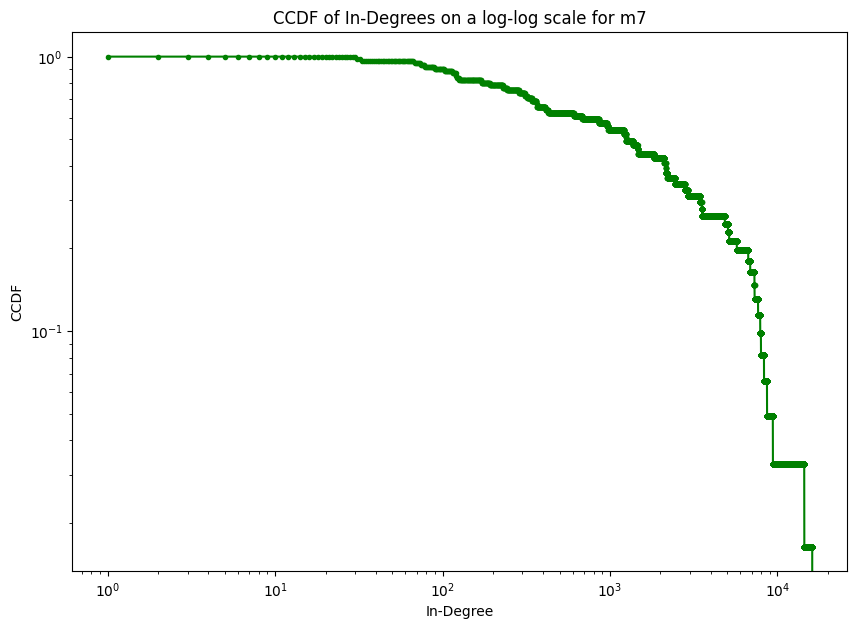

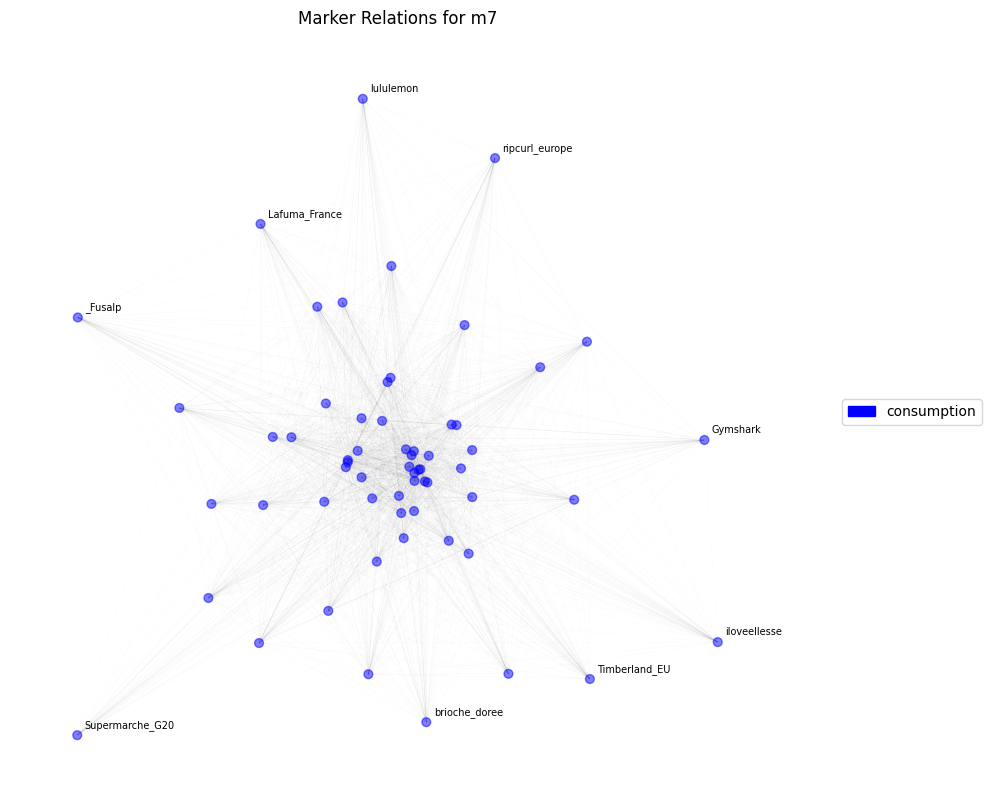

Number of communities: 3
Marker: Fnac, Type: consumption, In-Degree Centrality: 0.3140788603012728
Marker: Cdiscount, Type: consumption, In-Degree Centrality: 0.2812852749990269
Marker: Dior, Type: consumption, In-Degree Centrality: 0.1826515122027169
Marker: CarrefourFrance, Type: consumption, In-Degree Centrality: 0.16852205052352962
Marker: CHANEL, Type: consumption, In-Degree Centrality: 0.16169086450507958


In [47]:
#m7
importlib.reload(ca_pipeline)
subset_name = 'm7'
labeled = ca_pipeline.PipelineCorAnalysis(m7_df, subset_name)
path = '/home/livtollanes/NewData/coordinates/'
#labeled.run_all(path)
labeled.perform_graph_checks()


Number of nodes: 108905
Edge number is sane - matches the number of rows in the inputted edgelist
Is the graph connected? True
Number of weakly connected components: 1
Size of largest weakly connected component: 108905
Number of strongly connected components: 108905
Size of largest strongly connected component: 1


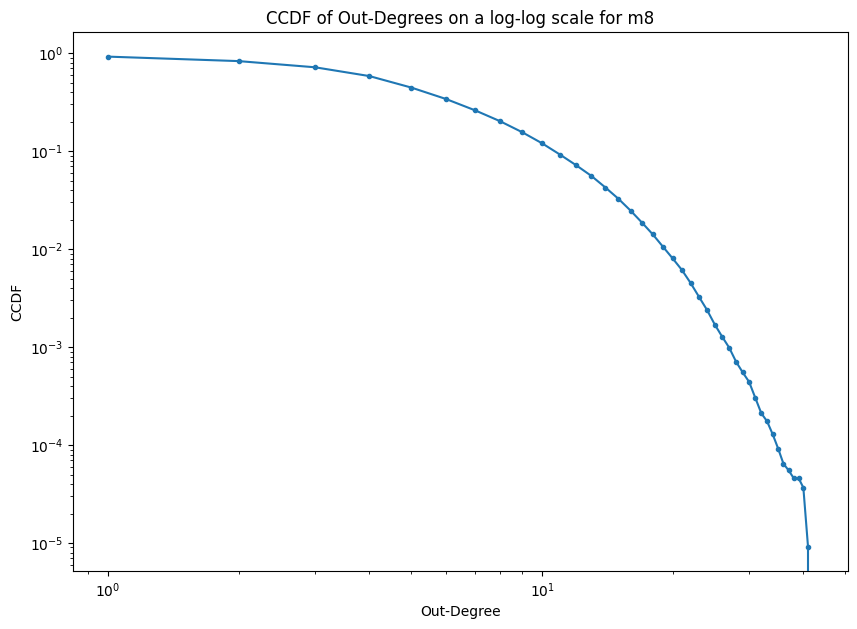

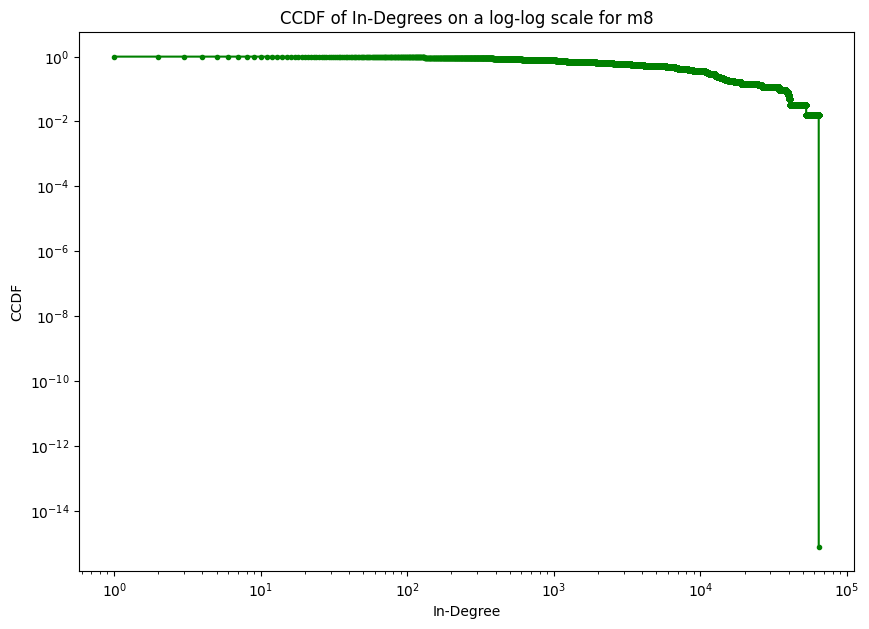

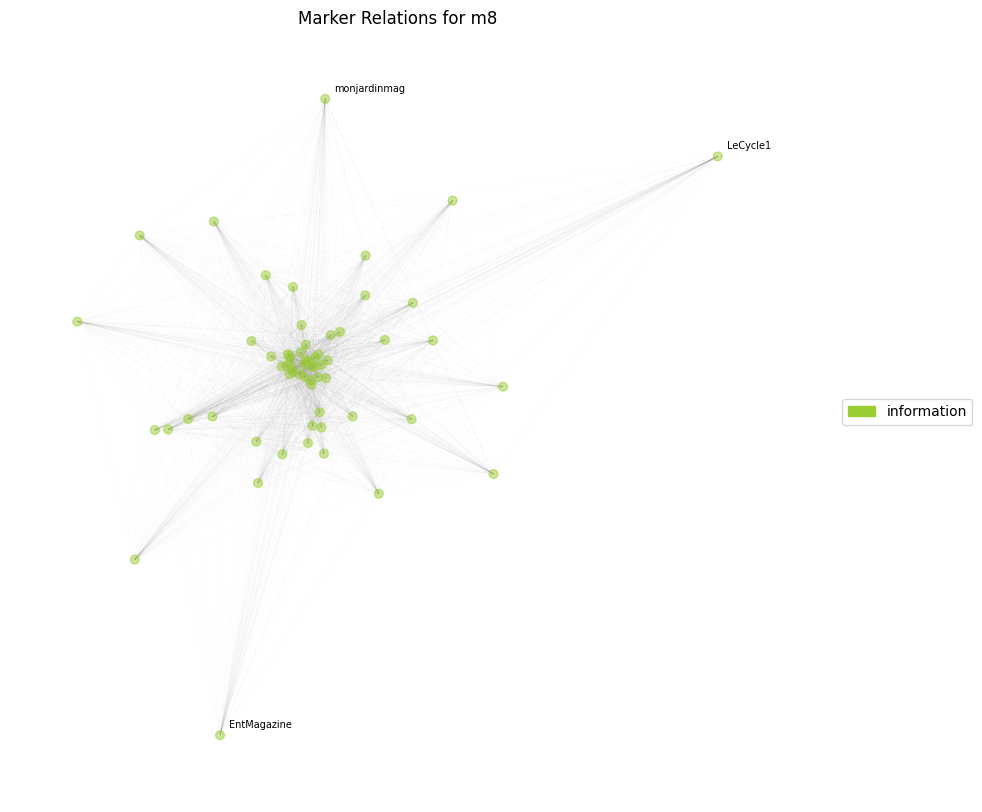

Number of communities: 3
Marker: Mediapart, Type: information, In-Degree Centrality: 0.5893263791963564
Marker: BFMTV, Type: information, In-Degree Centrality: 0.48337067508998754
Marker: LEXPRESS, Type: information, In-Degree Centrality: 0.37462352163373247
Marker: franceculture, Type: information, In-Degree Centrality: 0.36864577976933816
Marker: Europe1, Type: information, In-Degree Centrality: 0.36180489238228164


In [48]:
#m8
importlib.reload(ca_pipeline)
subset_name = 'm8'
labeled = ca_pipeline.PipelineCorAnalysis(m8_df, subset_name)
path = '/home/livtollanes/NewData/coordinates/'
#labeled.run_all(path)
labeled.perform_graph_checks()


Number of nodes: 36633
Edge number is sane - matches the number of rows in the inputted edgelist
Is the graph connected? True
Number of weakly connected components: 1
Size of largest weakly connected component: 36633
Number of strongly connected components: 36633
Size of largest strongly connected component: 1


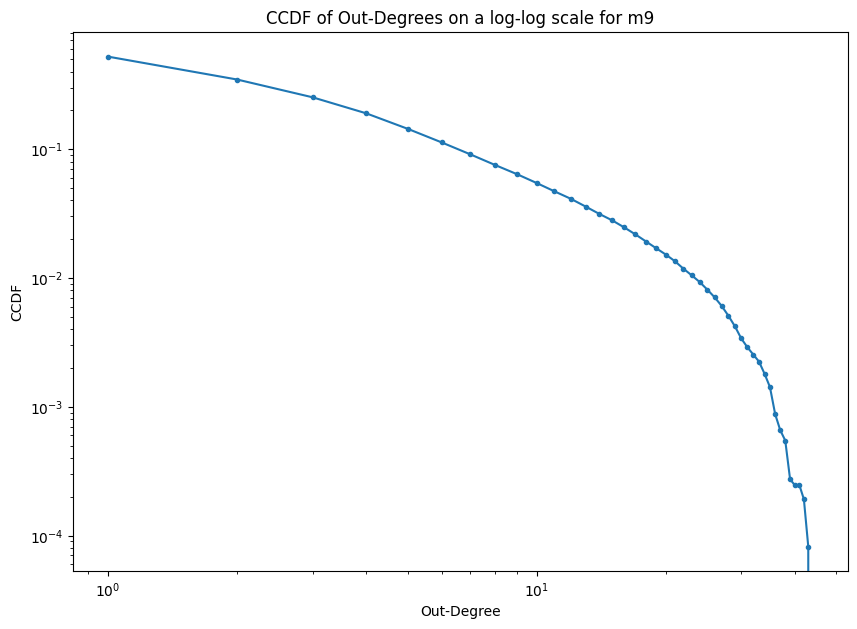

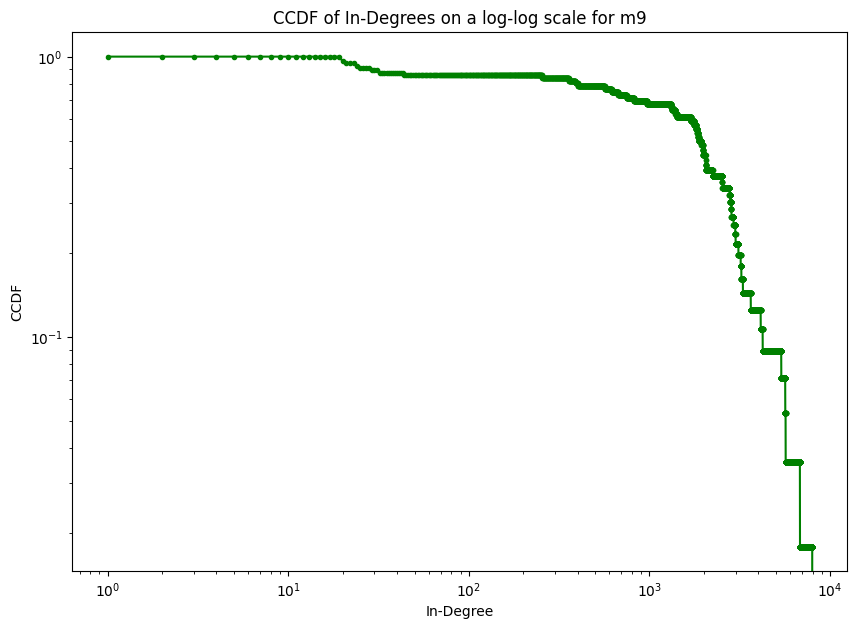

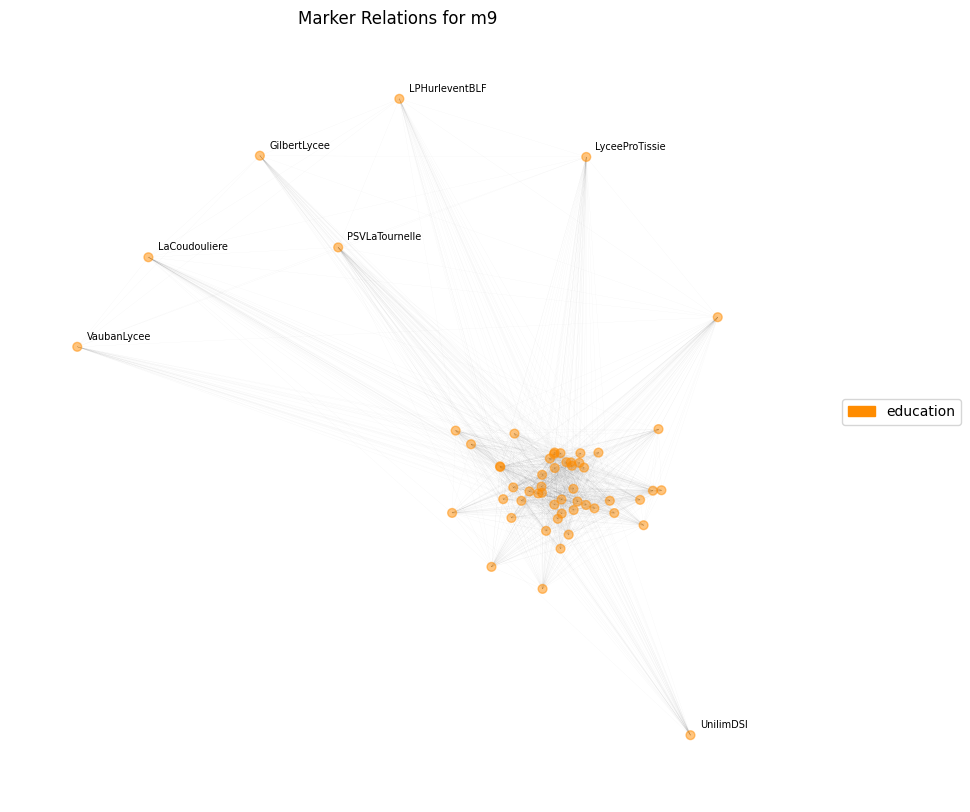

Number of communities: 3
Marker: sciencespo, Type: education, In-Degree Centrality: 0.21754203974666958
Marker: cdf1530, Type: education, In-Degree Centrality: 0.18584843852369512
Marker: SorbonneParis1, Type: education, In-Degree Centrality: 0.15483730072068136
Marker: EHESS_fr, Type: education, In-Degree Centrality: 0.1540729416903254
Marker: HECParis, Type: education, In-Degree Centrality: 0.14645664992356408


In [49]:
#m9
importlib.reload(ca_pipeline)
subset_name = 'm9'
labeled = ca_pipeline.PipelineCorAnalysis(m9_df, subset_name)
path = '/home/livtollanes/NewData/coordinates/'
#labeled.run_all(path)
labeled.perform_graph_checks()
